This notebook contains code to compute the FFT of a list of data or a matrix, and the IFFT

The FFT (Fast Fourier Transform) is a method to compute the DFT (Discrete Fourier Transform), which is defined as:

$$
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i \tau k n / N}
$$

by splitting the input list (x) into its even and odd components (0-indexed), and then computing the DFT of each section (i.e recursively FFT until you get to single points, when the resultant DFT is just the value of the single point of data), then reconstruct using twiddle factors, defined as:

$$
e^{-i \tau n / N}
$$

The FFT has a big-O notation of O(n log n) rather than the DFT, which has a big-O notation of O(n^2), thus making it much better for computation than the DFT without any optimisations.

For the following implementation, a simple radix-2 FFT will be used, and this will require the input list/matrix to have dimensions that are a power of 2

The following code will add and use libraries required (feel free to comment out the adding packages section if the packages are already installed)

In [1]:
# Addition section
using Pkg

# Pkg.add("Colors")
# Pkg.add("Plots")
# Pkg.add("BenchmarkTools")
# Pkg.add("FileIO")
# Pkg.add("ImageIO")
# Pkg.add("Images")

# Import section
using Plots
using BenchmarkTools
using Images
using FileIO
using Colors

The following code will define functions that are used for convenience when doing an FFT (1-D or 2-D)

In [2]:
# Useful for both

# Checks if the integer supplied is a power of 2
function ispow2(x::Int64)
    return x > 0 && (x & (x - 1)) == 0
end

# Finds the next power of 2 above the supplied integer (returns the integer supplied if it is a power of 2)
function nextpow2(x::Int64)
    return ispow2(x) ? x : convert(Int, 2^ceil(log2(x)))
end

# 1-D FFT functions

# Pad a vector to a length of a power of 2
function pad_vector(x::Vector{T}, padder::T, l::Int64) where T <: Number
    if l <= length(x)
        return x
    end

    return vcat(x, [padder for i in length(x) + 1:l])
end

# 2-D FFT functions

# Makes displaying a matrix much more concise and neat as all entries truncated to 2.d.p
function format_matrix(A::Matrix{T}) where T <: Number
    if !(T <: Real)
        return map(x -> round(real(x), digits = 2) + im * round(imag(x), digits = 2), A)
    else
        return map(x -> round(x, digits = 2), A)
    end
end

# Pads matrix so both of its dimensions are a power of 2
function pad_matrix_for_fft(A::Matrix{Float64})
    m, n = size(A)
    m_padded, n_padded = nextpow2(m), nextpow2(n)
    A_padded = zeros(Float64, m_padded, n_padded)
    A_padded[1:m, 1:n] = A
    return A_padded
end

# Pads a matrix to custom dimensions, useful for FFT convolution 
function pad_matrix(A::Matrix{T}, m::Int64, n::Int64) where T <: Number
    A_padded = zeros(T, m, n)
    A_padded[1:size(A, 1), 1:size(A, 2)] = A
    return A_padded
end

# Returns a vector of the rows of the matrix
function rows(matrix::Matrix)
    m = size(matrix)[begin]

    return [matrix[i, begin:end] for i in 1:m]
end

# Returns a vector of the columns of the matrix
function columns(matrix::Matrix)
    n = size(matrix)[end]

    return [matrix[begin:end, i] for i in 1:n]
end


# Given a vector of rows or columns, this function will convert the vector to a matrix
# columns is used to specify whether the vector supplied is a vector of columns (true) or a vector of rows (false)
function convert_to_matrix(v::Vector{Vector{T}}, columns::Bool = false) where T <: Number
    if columns
        m, n = length(v[1]), length(v)
        matrix = zeros(T, m, n)
        for i in 1:n
            matrix[begin:end, i] = v[i]
        end
        return matrix
    else 
        m, n = length(v), length(v[1])
        matrix = zeros(T, m, n)
        for i in 1:m
            matrix[i, begin:end] = v[i]
        end
        return matrix
    end
end

convert_to_matrix (generic function with 2 methods)

The following functions are a 1-D FFT of a list of data, and then a 1-D IFFT of a list of data

Because of the following, when doing a 1-D FFT with a purely real input, one can optimise the calculation of the twiddle factors

$$
X_{N - k} 
\newline = \sum^{N-1}_{n=0} x_n \cdot e^{-i \tau n (N - k) / N}
\newline = \sum^{N-1}_{n=0} x_n \cdot 1 \cdot e^{-i \tau n k }
\newline = X_k^{\ast}
          
$$

In [3]:
function fft(x::Vector{T}) where T <: Number 
    N = length(x)

    if !ispow2(N)
        throw(ArgumentError("Ensure list is a length of a power of 2"))
    elseif N == 1
        return x
    end
    
    X_even = fft(x[1:2:end])
    X_odd = fft(x[2:2:end])
    factors::Vector{ComplexF64} = [] 
    
    if T <: Real
        factors_first = @. exp(-2pi * im * (0:N÷2) / N)
        factors_rest = reverse(@. conj(factors_first[2:end - 1]))
        factors = vcat(factors_first, factors_rest)
    else
        factors = @. exp(-2pi * im * (0:N-1) / N)
    end

    return vcat(X_even .+ factors[begin:N÷2] .* X_odd, X_even .+ factors[(1 + N÷2):end] .* X_odd)
end

function ifft(x::Vector{T}, normalise::Bool = true) where T <: Number
    N = length(x)

    if !ispow2(N)
        throw(ArugmentError("Ensure list is a length of a power of 2"))
    elseif N == 1
        return x
    end

    X_even = ifft(x[1:2:end])
    X_odd = ifft(x[2:2:end])
    factors = @. exp(2pi * im * (0:N-1) / N)

    return vcat(X_even .+ factors[begin:N÷2] .* X_odd, X_even .+ factors[1 + N÷2:end] .* X_odd)  ./ (normalise ? sqrt(N) : 1)
end

ifft (generic function with 2 methods)

The following functions are a 2D FFT followed by a 2D IFFT

A 2D FFT is an FFT along the columns, then applying an FFT along the rows of the resultant matrix.

A 2D IFFT is an IFFT along the columns, then applying an IFFT along the rows of the resultant matrix.

In [4]:
function fft2(A::Matrix{T}) where T <: Number
    m, n = size(A)

    if !(ispow2(m) && ispow2(n))
        throw(ArgumentError("Dimensions should be a power of 2"))
    end

    columns_fft_matrix = convert_to_matrix([fft(i) for i in columns(A)], true)
    return convert_to_matrix([fft(i) for i in rows(columns_fft_matrix)])
end

function ifft2(A::Matrix{T}) where T <: Number
    m, n = size(A)

    if !(ispow2(m) && ispow2(n))
        throw(ArgumentError("Dimensions should be a power of 2"))
    end

    columns_ifft_matrix = convert_to_matrix([ifft(i) for i in columns(A)], true)
    return convert_to_matrix([ifft(i) for i in rows(A)])
end

ifft2 (generic function with 1 method)

The FFT and IFFT are very useful for computing convolutions, because of the convolution theorem:

$$
\mathcal{F}\{x(t) \ast y(t)\} = \mathcal{F} \{x(t)\} \cdot \mathcal{F} \{y(t)\}
$$

thus meaning that:

$$
x(t) \ast y(t) = \mathcal{F}^{-1}\{\mathcal{F} \{x(t)\} \cdot \mathcal{F} \{y(t)\}\}
$$

and this applies to both lists and matrices.

The following code contains functions that execute convolutions of 1-D lists and 2-D matrices respectively.

In [5]:
function conv(list1::Vector{T}, list2::Vector{T}) where T <: Number
    length_required = nextpow2(length(list1) + length(list2) - 1)
    list1_padded = pad_vector(list1, 0.0, length_required)
    list2_padded = pad_vector(list2, 0.0, length_required)

    fft_1 = fft(list1_padded)
    fft_2 = fft(list2_padded)

    return (ifft(fft_1 .* fft_2) .* (list1[begin] == 0 || list2[begin] == 0 ? 2 : 1))[begin:length(list1) + length(list2) - 1] # When one of the lists start with 0 the result seems to be half of what is expected, so this compensates for that
end

function conv2(A::Matrix{T}, B::Matrix{T}) where T <: Number
    m, n = nextpow2(size(A)[1] + size(B)[1] - 1), nextpow2(size(A)[2] + size(B)[2] - 1)

    A_padded = pad_matrix(A, m, n)
    B_padded = pad_matrix(B, m, n)

    return ifft2(fft2(A_padded) .* fft2(B_padded))
end

conv2 (generic function with 1 method)

The following code will benchmark the FFT convolutions agains simply sliding a list/matrix over another, then multiplying terms and summing.

In [6]:
function normal_conv(A::Vector{T}, B::Vector{T}) where T <: Number
    result_length = length(A) + length(B) - 1
    result = zeros(T, result_length)

    for i in 1:length(A)
        for j in 1:length(B)
            result[i + j - 1] += A[i] * B[j]
        end
    end

    return result
end

function normal_conv2(A::Matrix{T}, B::Matrix{T}) where T <: Number
    result_rows = size(A, 1) + size(B, 1) - 1
    result_cols = size(A, 2) + size(B, 2) - 1
    result = zeros(T, result_rows, result_cols)

    for i in 1:size(A, 1)
        for j in 1:size(A, 2)
            for m in 1:size(B, 1)
                for n in 1:size(B, 2)
                    result[i + m - 1, j + n - 1] += A[i, j] * B[m, n]
                end
            end
        end
    end

    return result
end

normal_conv2 (generic function with 1 method)

In [11]:
vec1 = rand(Float64, 20000)
vec2 = rand(Float64, 30000)

@time begin
    print("Normal 1-D convolution: ")
    normal_conv(vec1, vec2)
end

@time begin
    print("FFT 1-D convolution: ")
    conv(vec1, vec2)
end

Normal 1-D convolution:   0.439464 seconds (3 allocations: 390.688 KiB)
FFT 1-D convolution: 

  0.422156 seconds (2.95 M allocations: 467.767 MiB, 11.59% gc time)


49999-element Vector{ComplexF64}:
 1.5873893183484716e-16 + 3.8240114158277904e-29im
 3.3344786897991717e-16 + 1.201925080255857e-28im
  3.791491748737665e-16 + 2.0064459179957105e-28im
 3.9589511731231705e-16 + 2.383116972894059e-28im
   5.25022048109003e-16 + 1.1798436962766845e-28im
  6.123291594186036e-16 + 1.549923258380698e-28im
  6.286643870401073e-16 + 1.50049844751493e-28im
  8.487110919154499e-16 + 1.5494380891256602e-28im
  8.618858363548412e-16 + 6.383869740010552e-29im
  8.205312877837305e-16 + 7.484485138137228e-29im
                        ⋮
  4.908770228285171e-16 + 5.267843404768701e-28im
  4.842568516623669e-16 + 6.246020118099672e-28im
  4.921144680858693e-16 + 3.413945361433463e-28im
  3.946010883040141e-16 + 4.838609122871399e-28im
 2.2712499658520053e-16 + 7.625323630664803e-28im
 2.3427952560644276e-16 + 7.98256096831239e-28im
 2.4887676937101675e-16 + 1.1490079666855752e-28im
 1.9225433721492177e-16 + 2.5512250175700497e-28im
 1.3057433511748355e-16 + 7.15708275

In [8]:
mat1 = rand(Float64, 1000, 100)
mat2 = rand(Float64, 500, 500)

@time begin
    print("Normal 2-D convolution: ")
    normal_conv2(mat1, mat2)
end

@time begin
    print("FFT 2-D convolution: ")
    conv2(mat1, mat2)
end

Normal 2-D convolution: 

 25.386912 seconds (12.54 k allocations: 7.690 MiB, 0.27% compilation time)
FFT 2-D convolution: 

 13.216034 seconds (156.39 M allocations: 20.620 GiB, 18.45% gc time, 7.77% compilation time)


2048×1024 Matrix{ComplexF64}:
     0.647128-3.10774e-14im  …           0.0+6.59014e-15im
    -0.252229-0.281613im        -3.55271e-15-1.42109e-14im
   0.00546243+0.00315469im      -2.91434e-16+5.55112e-16im
   -0.0445143+0.024983im        -8.88178e-16-8.88178e-16im
  0.000759421+0.000432635im      1.21431e-17+7.37257e-18im
    -0.005734-0.0106768im    …           0.0-2.22045e-16im
  -0.00124382+0.00142955im      -1.17961e-16+8.32667e-17im
  -0.00932629+0.00285481im      -2.77556e-16+8.32667e-17im
  0.000226968+0.00046102im       3.46945e-18+1.21431e-17im
 -0.000431412-0.00275199im       1.38778e-17-2.77556e-17im
             ⋮               ⋱  
 -0.000431412+0.00275199im      -1.45717e-16+2.77556e-17im
  0.000226968-0.00046102im   …   1.38778e-17+6.07153e-18im
  -0.00932629-0.00285481im      -1.11022e-16-2.22045e-16im
  -0.00124382-0.00142955im       1.38778e-17-1.11022e-16im
    -0.005734+0.0106768im       -1.66533e-16+4.44089e-16im
  0.000759421-0.000432635im      1.21431e-17+3.03577

The following code tests to see how much accuracy is lost after doing an FFT and then an IFFT of a list of data

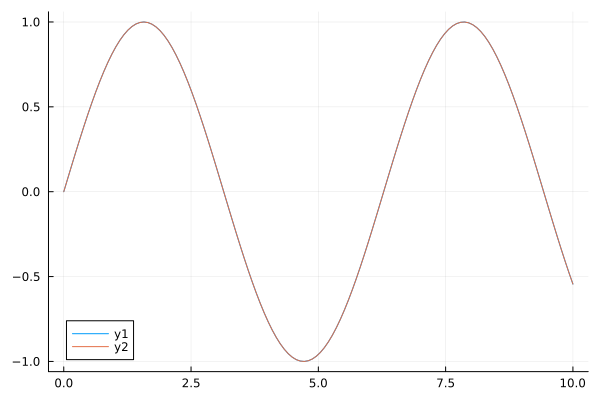

In [9]:
x = range(0, 10, length = 128)

y = @. sin(x)

y_after_processing = collect(map(x -> real(x), ifft(fft(y)))) * 128 # remove any tiny imaginary parts to ensure each element is real (also multiply by 128 for correct normalisation)

plot(x, [y, y_after_processing])

The following code tests the use of the convolution by convolving an image with a kernel to blur the image.

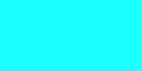

In [48]:
image = load("image.jpeg")

red_matrix = map(x -> Float64(x.r), image)
green_matrix = map(x -> Float64(x.g), image)
blue_matrix = map(x -> Float64(x.b), image)

kernel = [0.1 0.1 0.1; 0.1 0.5 0.1; 0.1 0.1 0.1]

red_convolved = map(x -> abs(real(x)), conv2(kernel, red_matrix))
green_convolved = map(x -> abs(real(x)), conv2(kernel, green_matrix))
blue_convolved = map(x -> abs(real(x)), conv2(kernel, blue_matrix))

red_n0f8 = map(x -> N0f8(x), red_convolved)
green_n0f8 = map(x -> N0f8(x), green_convolved)
blue_n0f8 = map(x -> N0f8(x), blue_convolved)

result = zeros(RGB{N0f8}, size(red_convolved, 1), size(red_convolved, 2))

for i in size(red_convolved, 1)
    for j in size(red_convolved, 2)
        result[i,j] = RGB(N0f8(255/255), N0f8(255/255), N0f8(255/255))
    end
end

colorview(RGB, [N0f8(.1) N0f8(.1)], [N0f8(1) N0f8(1)], [N0f8(1) N0f8(1)])

In [11]:
# Test the code results

kernel = [0.05 0.1 0.05; 0.1 0.5 0.1; 0.05 0.1 0.05]
matrix = map(x -> float(x), [
    1 1 1 1 1;
    1 2 3 2 1;
    1 3 5 3 1;
    1 2 3 2 1;
    1 1 1 1 1;
])

# display(format_matrix(fft2(pad_matrix_for_fft(matrix))))
display(fft([1, 1, 1, 1, 1, 0, 0, 0]))

8-element Vector{ComplexF64}:
                    5.0 - 0.0im
 1.7225464241988333e-16 - 2.414213562373095im
     0.9999999999999999 - 1.2246467991473532e-16im
 1.7225464241988333e-16 - 0.41421356237309503im
                    1.0 - 2.4492935982947064e-16im
 1.7225464241988333e-16 + 0.4142135623730947im
     1.0000000000000002 - 1.2246467991473532e-16im
 1.7225464241988333e-16 + 2.414213562373095im